## Sampling Data Streams

Exercises exploring distributions within a stream of tweets, etc., or some potentially unlimited stream of data. One of the biggest challenges with data mining streams is that  **we have limited storage capacity for the very high volume of incoming data, which may arrive at a very high velocity as well**. In these real-world scenarios, **we cannot store or process all tweets at once, but are constrained to deal with only one or a few tweets at a time**. 

Sampling allows us to maintain a compact representation of the entire data stream and we hope that the distribution of emojis in the sample we collect sheds light on the overall distribution of emojis in the data stream. For this exercise, in an effort to simulate real-world situations in a repeatable process, we will generate a `TwitterStream` class to simulate a Twitter stream. It works the same way as a `list`, `tuple` or any other `iterable`s that you may have worked with before --- you can loop over it to receive **one tweet at a time**. Each tweet may or may not contain emojis. There's also a helper function `extract_emojis` that helps you extract all emojis from a piece of text. It may be also useful to know that the variable `UNICODE_EMOJI` is a collection of all emojis that are circulating around the world.

<u><b>WARNING:</b></u> This is real Twitter data, and may contain triggering concepts as tweeted by real individuals.
_________________________

#### Generate `TwitterStream`

In [1]:
# !pip install emoji

In [2]:
import json
from emoji import UNICODE_EMOJI

def extract_emojis(text):
    """
    Extract all emojis from a str
    """
    return [ch for ch in text if ch in UNICODE_EMOJI]

class TwitterStream:
    """
    Used to simulate a Twitter stream. 
    """
    
    def __init__(self, data_file):
        self.data_file = data_file
        self.data = open(self.data_file, "r")
    
    def __iter__(self):
        return self.reset()
    
    def __next__(self):
        next_line = self.data.readline()
        if next_line:
            return json.loads(next_line)["text"]
        else:
            raise StopIteration
    
    def __del__(self):
        if not self.data.closed:
            self.data.close()
    
    def reset(self):
        if not self.data.closed:
            self.data.close()
        self.data = open(self.data_file, "r")
        return self

How to call and interact with `TwitterStream`

In [3]:
twitter_stream = TwitterStream("../assets/tweets")  # instantiate a Twitter stream from a data file

# use a for-loop to iterate through the stream, just like iterating over a list
for index, tweet in enumerate(twitter_stream):
    print(index, tweet)
    if index >= 3:  # only prints the first 4 tweets
        break

twitter_stream.reset() # reset the stream so that it begins with the first tweet
print()

# OR
# use a while-loop together with the "next" function to retrieve one tweet from the stream at a time
index = 0
while index < 4: 
    print(index, next(twitter_stream)) # the built-in "next" function retrieves the next item in an iterator
    index += 1

del twitter_stream, index

0 Recently arrived in Australia - just been out on my evening dog walk and decided to give @petercrouch podcast a listen - wow...what have I been missing - absolutely hilarious! #thatpetercrouchpodcast
1 Lmaoooooo love you allll
2 Good morning! kita mo nga naman isang panibagong araw para maging malungkot ulit🤧
3 Here we go ⚓️

0 Recently arrived in Australia - just been out on my evening dog walk and decided to give @petercrouch podcast a listen - wow...what have I been missing - absolutely hilarious! #thatpetercrouchpodcast
1 Lmaoooooo love you allll
2 Good morning! kita mo nga naman isang panibagong araw para maging malungkot ulit🤧
3 Here we go ⚓️


Many sampling algorithms require "tossing a coin", that is, a psudo-random generator (PRG). To understand our data a little better, we will create a "history-preserving" PRG. It will basically work the same way as the `random` library.

In [4]:
from random import Random
from collections import defaultdict

class HistPresvRandom:
    """
    History-preserving Random Number Generator
    """
    
    def __init__(self, seed=None):
        self.prg = Random(seed)
        self.hist = defaultdict(list)
    
    def random(self): # works exactly like random.random()
        num = self.prg.random()
        self.hist["random"].append(num)
        return num
    
    def sample(self, population): # works exactly like random.sample(population, 1)[0]
        num = self.prg.sample(population, 1)[0]
        self.hist["sample"].append(num)
        return num

hist_presv_random = HistPresvRandom(0)
print(f'"random" method: {hist_presv_random.random()}')
print(f'"sample" method: {hist_presv_random.sample(range(10))}')

del hist_presv_random

"random" method: 0.8444218515250481
"sample" method: 6


_______
#### Random Sampling

Implement a random sampling algorithm. The `RandomSampler` object should behave the following way:

* `_process_new_item`: it receives a single item and decides whether the item should be added to `self.sample`. It also ensures `self.counts` always has the most updated counts of emojis that are extracted from the tweets in `self.sample`. 


* `do_sampling`: it receives a stream object and iterates over the stream. During each iteration, it processes a new item as specified by the Random Sampling algorithm. Finally it returns a copy of `self.sample` and `self.counts` at every iteration (for historical reference and debugging).

In [5]:
from collections import defaultdict

class RandomSampler:
    
    def __init__(self, in_sample_prob, seed=None):
        
        self.in_sample_prob = in_sample_prob
        self.random = HistPresvRandom(seed) # used whenever randomness is needed in your solution
        self.sample, self.counts = list(), defaultdict(int) # recommended to use defaultdict, but an ordinary dict works fine too
    
    def _process_new_item(self, item):
        """
        Applies random sampling to a newly arrived item
        """
        
        if self.random.random() < self.in_sample_prob:
            self.sample.append(item)
            for emoji in extract_emojis(item):
                self.counts[emoji] += 1
            
    def do_sampling(self, stream):
        """
        Iterates over a stream and performs random sampling
        """
        
        self.sample.clear() # clear the existing sample
        self.counts.clear() # clear the existing counts
        
        for item in stream: # iterate over the stream
            
            self._process_new_item(item)
            
            # returns a copy of sample and counts at the end of every iteration for grading - code given
            yield self.sample.copy(), self.counts.copy()

Let's see the distribution of the processed tweets:

In [6]:
in_sample_prob, seed = 0.1, 42
random_sample = RandomSampler(in_sample_prob, seed)
twitter_stream = TwitterStream("../assets/tweets")

# Do sampling. Don't have to collect the results. Just exhaust the stream
for _ in random_sample.do_sampling(twitter_stream):
    pass

sorted_counts = {emoji: random_sample.counts[emoji] for emoji in sorted(random_sample.counts.keys(), key=random_sample.counts.get, reverse=True)}
print(sorted_counts)

{'😂': 194, '😭': 69, '❤': 57, '🤣': 51, '✨': 50, '🏻': 40, '🔥': 37, '🥺': 35, '🙏': 32, '👏': 32, '😍': 30, '👍': 29, '♥': 23, '💕': 21, '🇸': 20, '♀': 20, '😅': 20, '☺': 18, '🥰': 17, '🇦': 16, '😎': 16, '🏽': 16, '💜': 16, '💚': 15, '🏾': 15, '😊': 14, '😆': 14, '😢': 14, '🍍': 14, '💪': 13, '😳': 13, '😩': 12, '‼': 12, '♂': 12, '🤭': 12, '💙': 11, '👇': 11, '💖': 10, '😱': 10, '💛': 10, '😹': 10, '🤔': 9, '🖤': 9, '🎉': 9, '🚨': 9, '🙄': 9, '♻': 9, '🙌': 8, '💦': 8, '❗': 8, '😷': 8, '🤷': 8, '😈': 8, '💀': 8, '⚡': 8, '😔': 7, '🥵': 7, '😁': 7, '⭕': 7, '🏅': 7, '💗': 7, '🌹': 7, '✌': 7, '⚠': 7, '😘': 6, '🌟': 6, '😌': 6, '🌸': 6, '🗣': 6, '🤪': 6, '😤': 6, '🤦': 6, '❣': 5, '🍑': 5, '💔': 5, '✊': 5, '🤤': 5, '💓': 5, '🦋': 5, '😇': 5, '💎': 5, '🇬': 5, '🇨': 5, '😥': 5, '⚰': 5, '🙂': 5, '👋': 5, '↙': 5, '👉': 5, '🐰': 5, '🐨': 5, '💣': 5, '🥳': 5, '✅': 5, '🐬': 5, '💘': 4, '😉': 4, '😐': 4, '🌺': 4, '💝': 4, '🇪': 4, '▶': 4, '🇧': 4, '👩': 4, '🙃': 4, '😄': 4, '😚': 4, '🤩': 4, '☀': 4, '🏃': 4, '⭐': 4, '▫': 4, '🇳': 4, '🔴': 4, '😙': 3, '🐶': 3, '☝': 3, '🇷': 3, '🥴': 3, '😡': 

Visualised in a bar graph, the emoji distribution seems to resemble a [Power Law](https://en.wikipedia.org/wiki/Power_law) distribution. A few emojis are used a lot while the majority of the emojis are rarely used. 

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax

_______
#### Reservoir Sampling

Implement a reservoir sampling function that does the following:

* `_process_new_item`: it receives a single item as well as the index of the item in the stream, and decides whether the item should be added to `self.sample`. **Append the new item to the end of the `self.sample` instead of replacing an old item with it.** Function also ensures `self.counts` always has the most updated counts of emojis that are extracted from the tweets *currently* in `self.sample`, which means that **the counts of emojis must be adjusted in the event of adding or removing an emoji to/from the sample**. Moreover, an emoji with a count of zero must be completely dropped from `self.counts`. 


* `do_sampling`: it receives a stream object and iterates over the stream. During each iteration, it processes a new item as specified by the Reservoir Sampling algorithm. Finally it returns a copy of `self.sample` and `self.counts` at every iteration (for historical reference and debugging).

In [8]:
from collections import defaultdict

class ReservoirSampler:
    
    def __init__(self, sample_size, seed=None):
        
        self.sample_size = sample_size
        self.random = HistPresvRandom(seed) # used whenever randomness is needed in your solution
        self.sample, self.counts = list(), defaultdict(int)
    
    def _process_new_item(self, item, index):
        """
        Decides whether a new item should be added to the sample and adjusts the counts accordingly
        """

        if len(self.sample) < self.sample_size:
            self.sample.append(item)
            for emoji in extract_emojis(item):
                self.counts[emoji] += 1
        else:
            coinflip = int(self.random.random() * index)
            index += 1
            if coinflip < self.sample_size:
                sample_item_to_delete = self.random.sample(self.sample)
                for emoji in extract_emojis(sample_item_to_delete):
                    self.counts[emoji] -=1
                    if self.counts[emoji] == 0:
                        del self.counts[emoji]#my_dict['key']
                self.sample.remove(sample_item_to_delete)
                #del self.sample[self.sample.index(sample_item_to_delete)]
                self.sample.append(item)
                for emoji in extract_emojis(self.sample[-1]):
                    self.counts[emoji] += 1
        
    
    def do_sampling(self, stream):
        """
        Iterates over a stream and performs reservoir sampling
        """
        
        self.sample.clear() # clear the existing sample
        self.counts.clear() # clear the existing counts
        
        for index, item in enumerate(stream): # iterate over the stream
            self._process_new_item(item, index)
            
            # returns a copy of sample and counts at the end of every iteration for grading - code given
            yield self.sample.copy(), self.counts.copy()
            


Let's see the distribution of the processed tweets:

Let's see what the emoji distribution is after all tweets are processed.

In [9]:
sample_size, seed = 100, 0
stu_ans = ReservoirSampler(sample_size, seed)

# Do sampling. Don't have to collect the results. Just exhaust the stream
for _ in stu_ans.do_sampling(TwitterStream("../assets/tweets")):
    pass

sorted_counts = {emoji: stu_ans.counts[emoji] for emoji in sorted(stu_ans.counts.keys(), key=stu_ans.counts.get, reverse=True)}
print(sorted_counts)

{'😭': 24, '🥰': 18, '❤': 11, '😂': 8, '💙': 8, '🥺': 7, '😍': 7, '🇸': 6, '🇺': 5, '✨': 4, '‼': 4, '♂': 3, '🏆': 3, '👍': 2, '💕': 2, '☺': 2, '❗': 2, '😘': 2, '👩': 2, '🙃': 2, '😋': 2, '🔥': 2, '👑': 2, '♥': 2, '😩': 2, '💚': 1, '😏': 1, '🎶': 1, '☀': 1, '🎵': 1, '👇': 1, '🏼': 1, '🐟': 1, '🤦': 1, '🐰': 1, '👫': 1, '💋': 1, '😈': 1, '🏀': 1, '🏈': 1, '🎤': 1, '😠': 1, '🌈': 1, '🇦': 1, '⚽': 1, '✌': 1, '😷': 1, '🏻': 1, '🤓': 1, '🤷': 1, '🏿': 1, '🐳': 1, '💰': 1, '✅': 1, '🥇': 1, '👏': 1, '👉': 1, '\U0001f9be': 1, '😞': 1, '📸': 1, '🤑': 1, '🙏': 1, '🏾': 1, '🙆': 1, '🏽': 1, '🍪': 1, '😇': 1, '😉': 1, '🥴': 1, '🏯': 1, '🦅': 1, '😱': 1, '😓': 1, '🤗': 1, '💓': 1, '😤': 1, '🐱': 1, '🐥': 1, '🍼': 1, '😪': 1}


Visualised in a bar graph, the emoji distribution seems to somewhat resemble a [Power Law](https://en.wikipedia.org/wiki/Power_law) distribution, too. A few emojis are used a lot while the majority of the emojis are rarely used. 

The distribution looks much like the Random Sampling, though the most used are not identical. 

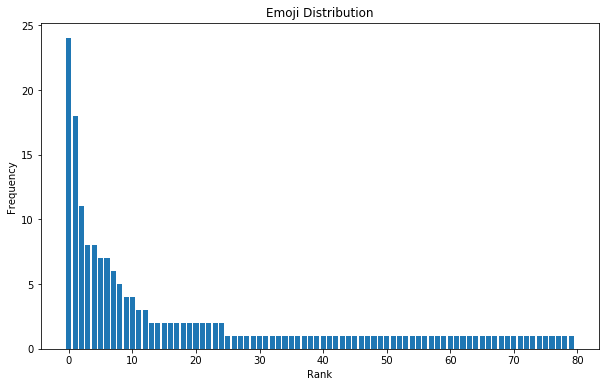

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax

____________
____________
#### Counting in a Data Stream

Implementing algorithms for counting items in a data stream. As previously mentioned, with a data stream we have limited storage capacity for for a high volume of data, which can come in at a high velocity. In cases of checking for distributions of some simly items, like emoji usage, it might be possible to obtain approximate counts directly without curating a whole sample like with the sampling exercises.

_____
#### Bloom Filters
First, we are going to look at a Bloom filter. This means that it is not actually counting the items in a data stream, but can tell that
* an item has <i>definitely not appeared</i> in the data stream so far, or
* an item has <i>possibly appeared</i> in the data stream so far

The Bloom filter will contain two functions:
* `check_appearance`: it receives a single item and returns a `bool` value indicating whether the item has appeared or not so far;

* `do_filtering`: it receives a stream object and iterates over the stream. During each iteration, it extracts all emojis from a tweet, computes the fingerprint of each emoji and records the appearance of each emoji accordingly, as specified in the lecture slides. Finally, it returns a copy of the `slots` of your `BloomFilter` for debugging.

First, we need a `HashFunction` class that provides simple and deterministic hash functions.

In [11]:
class HashFunction:
    def __init__(self, num_slots):
        self.num_slots = num_slots
        
    def __call__(self, x):
        return (hash(self) + hash(x)) % self.num_slots

In [12]:
# Check hash function
h1, h2 = HashFunction(7919), HashFunction(7919)

# The two hash functions are distinct, but both are deterministic
print(h1("😂"), h2("😂"))
print(h1("😂"), h2("😂"))

del h1, h2

250 446
250 446


<b>Note:</b> The two different instantiations of the `HashFunction` class lead to two distinct hash functions. They assign different fingerprints to the same emoji, but both are deterministic. They will always have the same fingerprint for each emoji, regardless of how many times they are applied. They can be re-run and return different fingerprints, but they will always be deterministic. (This is relevant for any future debugging.)

In [13]:
import numpy as np

class BloomFilter:
    
    def __init__(self, num_slots, num_hash_fns):
        
        self.slots = np.zeros(num_slots, dtype=int)
        self.hash_fns = [HashFunction(num_slots) for _ in range(num_hash_fns)] # A list of distinct hash functions
    
    def check_appearance(self, item):
        """
        Returns a bool value indicating whether an item has appeared or not
        """
        
        has_appeared = None

        for emoji in extract_emojis(item):
            seen = []
            for i in self.hash_fns:
                if self.slots[i(emoji)] == 1:
                    seen.append(True)
                else:
                    seen.append(False)

            if all(seen) == True:
                has_appeared = np.bool_(True)
            else:
                has_appeared = np.bool_(False)
        
        return has_appeared
    
    def do_filtering(self, stream):
        """
        Iterates over a stream, collects items of interest, calculates the fingerprints and records the appearance
        """
        
        self.slots = np.zeros_like(self.slots) # reset the slots
        
        for item in stream: # iterate over the stream

            for emoji in extract_emojis(item):
                if self.check_appearance(emoji) == False:
                    for i in self.hash_fns:
                        self.slots[i(emoji)] = 1
            
            
            # returns a copy of slots at the end of every iteration for grading - code given
            yield self.slots.copy()

In [14]:
twitter_stream = TwitterStream("../assets/tweets")
num_slots, num_hash_fns = 7919, 5
bloom_filter = BloomFilter(num_slots, num_hash_fns)

# Collect emojis that appeared and that didn't appear
emojis_appeared = set()
for tweet in twitter_stream:
    emojis_appeared = emojis_appeared.union(extract_emojis(tweet))
emojis_not_appeared = set(UNICODE_EMOJI.keys()) - emojis_appeared

# Do filtering. Don't have to collect the results. Just exhaust the stream
for _ in bloom_filter.do_filtering(twitter_stream):
    pass

Check if a certain emoji has occurred:

In [15]:
bloom_filter.check_appearance("😂")

True

In [16]:
bloom_filter.check_appearance("🦠")

True

_____
#### Lossy Counter
Let's try a Lossy Counter. The counter should maintain counts of all emojis seen so far, and only update counts once a "bucket" of tweets arrive. The "update" of counts should include increments due to the emojis contained in the new bucket and decrements because we want to gradually get rid of less recent emojis. 

In [17]:
from collections import defaultdict

class LossyCounter:
    
    def __init__(self, bucket_size):
        
        self.bucket_size = bucket_size
        self.counts = defaultdict(int) # recommended to use defaultdict, but an ordinary dict works fine too
    
    def do_counting(self, stream):
        """
        Iterates over a stream, counts the items and drops the infrequent ones in a bucket
        """
        
        self.counts.clear() # reset the counts
        num_items_in_bucket = 0 # optional: the current number of items in the "bucket"
        
        for item in stream: # iterate over the stream
            num_items_in_bucket += 1 # possible issue? ****
            
            if num_items_in_bucket < self.bucket_size:
                for emoji in extract_emojis(item):
                    self.counts[emoji] += 1
                yield self.counts.copy()
                continue
    
#             print(num_items_in_bucket)
            for emoji in extract_emojis(item):
                self.counts[emoji] += 1

            # Decrement existing counts to leave just more relevant ones
            to_del = []    
            for k,v in self.counts.items():
                if self.counts[k] > 1:
                    self.counts[k] -= 1
                else:
                    to_del.append(k)

            for i in to_del:
                del self.counts[i]

                
                # Reset variables
                num_items_in_bucket = 0
#                 print(num_items_in_bucket)
                bucket_counts = defaultdict(int)


            # returns a copy of counts at the end of every iteration for grading - code given
            yield self.counts.copy()

In [18]:
bucket_size = 100
lossy_cnt = LossyCounter(bucket_size)

# Do counting. Don't have to collect the results. Just exhaust the stream
for _ in lossy_cnt.do_counting(TwitterStream("../assets/tweets")):
    pass

sorted_counts = {emoji: lossy_cnt.counts[emoji] for emoji in sorted(lossy_cnt.counts.keys(), key=lossy_cnt.counts.get, reverse=True)}
print(sorted_counts)

{'😂': 1304, '😭': 911, '❤': 592, '🤣': 401, '🥺': 318, '✨': 317, '🥰': 236, '🔥': 231, '🏻': 228, '🙏': 207, '😍': 205, '💙': 175, '👏': 106, '♥': 97, '♀': 94, '😊': 77, '👍': 72, '💕': 69, '☺': 53, '‼': 47, '🤔': 44, '♂': 25, '💜': 22, '🏼': 21, '😅': 18, '👇': 16, '💦': 13, '😔': 13, '💔': 12, '🤒': 11, '🙇': 11, '💎': 11, '⭐': 10, '😢': 10, '🤦': 9, '👑': 9, '🌸': 7, '😆': 7, '🏾': 7, '🏷': 7, '🏽': 6, '😘': 6, '🤷': 6, '💀': 5, '🙄': 5, '❗': 5, '💢': 5, '💚': 4, '😋': 4, '🇸': 4, '😹': 4, '🤐': 4, '👥': 4, '💥': 4, '💛': 3, '🐥': 3, '😡': 2, '🎁': 2, '💪': 2, '😠': 2, '🤤': 2, '🚨': 2, '🤪': 2, '📣': 2, '😀': 2, '🍆': 2, '😏': 2, '🤮': 1, '😩': 1, '🤭': 1, '🔘': 1, '🖤': 1, '😃': 1, '👀': 1, '▶': 1, '😷': 1, '😁': 1, '〰': 1}


Yet again, visualised in a bar graph, the emoji distribution seems to resemble a [Power Law](https://en.wikipedia.org/wiki/Power_law) distribution. A few emojis are used a lot while the majority of the emojis are rarely used. 

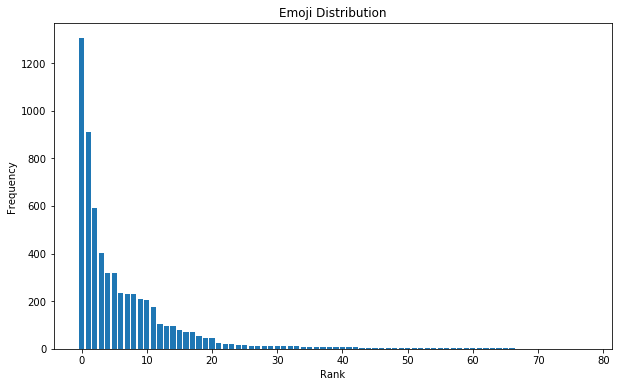

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax

______________________
<div style="text-align: right"><sub>Exercise adapted and modified from UMSI homework assignment for SIADS 632.</sub></div>